In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import sys
import imageio
from pathlib import Path
from glob import glob
from scipy.signal import correlate
from tqdm import tqdm
import cv2
from scipy.ndimage import zoom
import os
from skimage.filters import frangi
from amftrack.pipeline.development.high_mag_videos.kymo_class import *



def vel_field(curr_frame, next_frame, win_size, segment, corr_thresh):
    ys = np.arange(0, curr_frame.shape[0], win_size)
    xs = np.arange(0, curr_frame.shape[1], win_size)
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            seg_win = segment[y : y + win_size, x : x + win_size]
            if np.sum(seg_win) < 5:
                continue
            int_win = curr_frame[y : y + win_size, x : x + win_size]
            search_win = next_frame[y : y + win_size, x : x + win_size]
            cross_corr = correlate(
                search_win - search_win.mean(), int_win - int_win.mean(), method="fft"
            )
            corr_check = cross_corr.max() / np.sum(abs(cross_corr))
            if corr_check > corr_thresh:
                dys[iy, ix], dxs[iy, ix] = (
                    np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
                    - np.array([win_size, win_size])
                    + 1
                )
    # draw velocity vectors from the center of each window
    ys = ys + win_size / 2
    xs = xs + win_size / 2
    return xs, ys, dxs, dys

F:\AMOLF_Projects\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


F:/AMOLF_Data/TEMP
This is not a linux system, I am lost


100%|██████████| 601/601 [00:01<00:00, 334.32it/s]


(array([2.727696e+06, 1.270500e+05, 7.620000e+04, 5.447600e+04,
        4.181100e+04, 2.297200e+04, 1.133300e+04, 7.148000e+03,
        2.894000e+03, 4.200000e+02]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

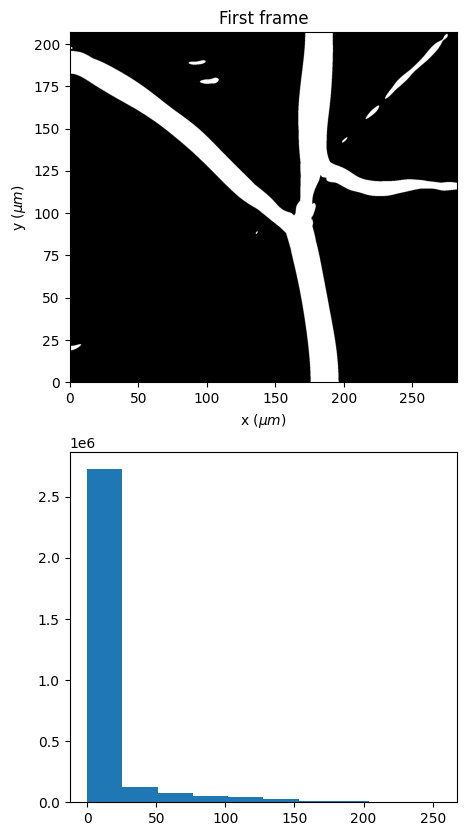

In [2]:
input_address = Path('F:\\AMOLF_Data\\Brightfield_videos\\20220118_Plate537_004\\')

video_address = input_address.joinpath('Img')


pics = [pic for pic in video_address.glob('*.tiff')]

# space_res = .08625
space_res = 2 * 1.725 / 50 * 2
fps = 20
noise_thresh = 20

frame = imageio.v3.imread(pics[0])
frame_res = frame.shape
frame_max = frame.copy()

for pic in tqdm(pics):
    pic_frame = imageio.v3.imread(pic)
    frame_max = np.maximum(frame_max, pic_frame)
vid_dimen = frame.shape
frangi_range = range(30, 160, 30)
vid_frangi = frangi(frame, frangi_range)
vid_frangi = vid_frangi * (255/np.max(vid_frangi))

vid_extent = [0, space_res * vid_dimen[1], 0, space_res*vid_dimen[0]]

segment = np.greater(vid_frangi, noise_thresh)

fag, ax = plt.subplots(2, figsize=(5,10))
ax[0].imshow(segment, extent=vid_extent, aspect='auto', cmap='gray', vmin=0)
ax[0].set_xlabel('x ($\mu m$)')
ax[0].set_ylabel('y ($\mu m$)')
ax[0].set_title('First frame')
ax[1].hist(vid_frangi.flatten())


In [3]:
# a = imageio.imread(pics[0])
# b = imageio.imread(pics[5])

speed_thresh = 20 * space_res
frame_range = np.arange(0, len(pics), 3)
xss = []
yss = []
dxss= []
dyss= []
norms=[]
oris= []
if not os.path.exists(input_address.joinpath("Analysis/PIV/")):
    os.makedirs(input_address.joinpath("Analysis/PIV/"))
pivanal_path = input_address.joinpath("Analysis/PIV/")


for i, frame_nr in enumerate(tqdm(frame_range)):
    if i == 0:
        continue
    else:
        curr_frame =  cv2.GaussianBlur(imageio.v3.imread(pics[frame_range[i-1]]), (5,5), 0)
        next_frame =  cv2.GaussianBlur(imageio.v3.imread(pics[frame_nr]), (5,5), 0)
        xs, ys, dxs, dys = vel_field(curr_frame, next_frame, 4, segment*1, 0.001)
        norm_drs = np.sqrt(dxs ** 2 + dys ** 2)
        ori_drs = np.arctan2(dys, dxs)
        
        xss.append(xs)
        yss.append(ys)
        dxss.append(dxs)
        dyss.append(dys)
        norms.append(norm_drs)
        oris.append(ori_drs)
    
        fig, ax = plt.subplots( figsize=(8, 6))
        # we need these flips on y since quiver uses a bottom-left origin, while our
        # arrays use a top-right origin
        ax.quiver(
            xs,
            ys,
            np.where(norm_drs < speed_thresh, dxs, np.nan),
            np.where(norm_drs < speed_thresh, dys, np.nan),
            np.where(norm_drs < speed_thresh, norm_drs, np.nan),
            cmap="plasma",
            angles="xy",
            scale_units="xy",
            scale=0.25,
        )
        ax.imshow(imageio.v3.imread(pics[frame_range[i-1]]))
        fig.savefig(pivanal_path.joinpath(f"{i:04}.png"))
        plt.close()
        

# xs, ys, dxs, dys = vel_field(a, b, 16, segment*1)


  0%|          | 0/201 [00:00<?, ?it/s]C:\Users\night\AppData\Local\Temp\ipykernel_23420\1104407514.py:33: RuntimeWarning: invalid value encountered in scalar divide
  corr_check = cross_corr.max() / np.sum(abs(cross_corr))
100%|██████████| 201/201 [15:01<00:00,  4.48s/it]


In [4]:
norms_adj = np.where(np.array(norms) < 20, norms, 0)
hues = (np.array(oris) + np.pi) / (2*np.pi)
vals = np.array(norms_adj) / np.max(norms_adj)
sats = np.ones(hues.shape)
hsvs = np.array([hues, vals, sats])
hsvs = np.transpose(hsvs, axes=[1,2,3,0])
color_out = np.array(hsv_to_rgb(hsvs) * 256, dtype=np.uint8)

hsvs_mean = hsv_to_rgb(np.max(hsvs, axis=0))

imageio.mimwrite(input_address.joinpath('Analysis'+os.sep+'out.mp4'),
                 color_out,
                fps=fps,
                quality=4)


2023-06-15 10:09:13,384-[WARNING]- imageio_ffmpeg:562 -> IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (512, 375) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


0
Found an xlsx file, using that data
              Unnamed: 0 Treatment Strain Time after crossing  \
5  20220118_Plate537_004  1%P100%N     C2              7 days   

   Growing temperature Position mm Unnamed: 6  dcenter mm  droot mm  \
5                 25.0       46260      43440         2.0       0.0   

  Bright-field (BF)\nor\nFluorescence (F) Binned (Y/N)  Magnification   FPS  \
5                                      BF            Y           50.0  20.0   

   Video Length (s) Comments  
5              30.0      NaN  
Analysing BRIGHT video of 50.0X zoom, with 20.0 fps
Using image selection 0 to 600
Succesfully extracted the skeleton. Did you know there is a skeleton inside inside you right now?


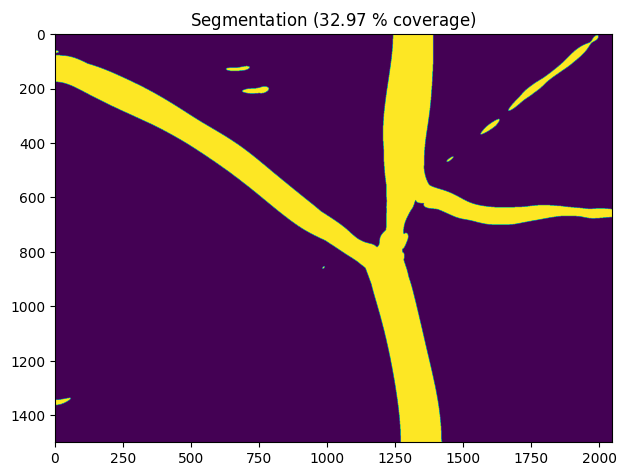

In [5]:
vid_analysis = Kymo_video_analysis(str(input_address), logging=True, vid_type=None,
                                 fps=None, binning=None, filter_step=80,
                                seg_thresh=13, show_seg=True)



 To work with individual edges, here is a list of their indices:
edge 0, (22, 9)
edge 1, (17, 4)
edge 2, (23, 22)
edge 3, (26, 13)
edge 4, (31, 26)


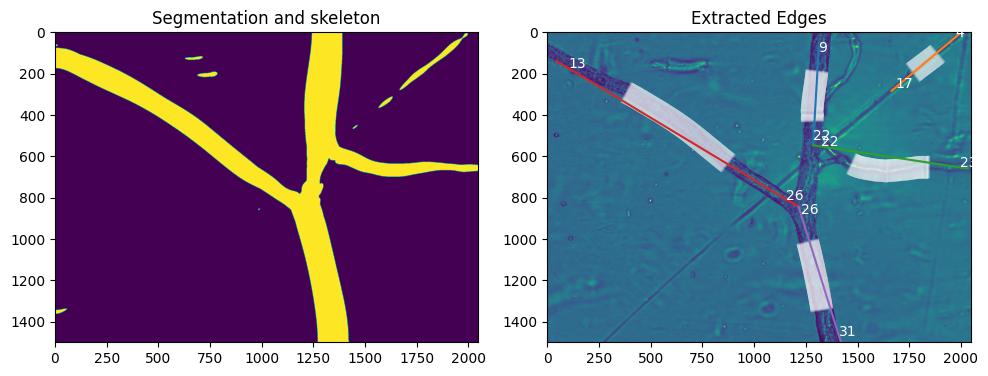

Saved the extracted edges


<Figure size 640x480 with 0 Axes>

In [6]:
edge_list = vid_analysis.edge_objects

### The print statement will give you the edge indices such that you can select which edges to analyze.
print('\n To work with individual edges, here is a list of their indices:')
for i, edge in enumerate(edge_list):
    print('edge {}, {}'.format(i, edge.edge_name))

### Target length here determines the *width* of the analysis box.
### Too shallow, and you won't capture the entire hypha, too big and the analysis is plagued with background.
target_length = int(1.9*vid_analysis.magnification)

vid_analysis.plot_extraction_img(target_length=target_length, save_img=True)

(200, 375, 512, 3)
375 512


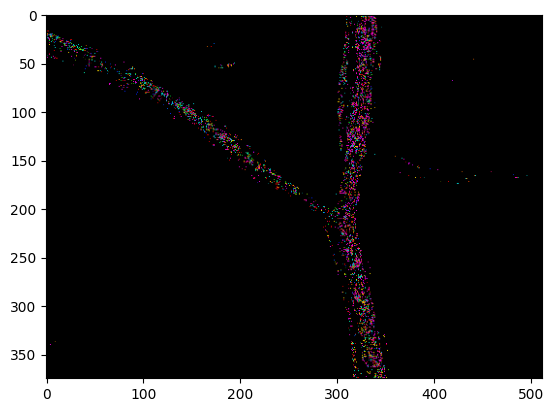

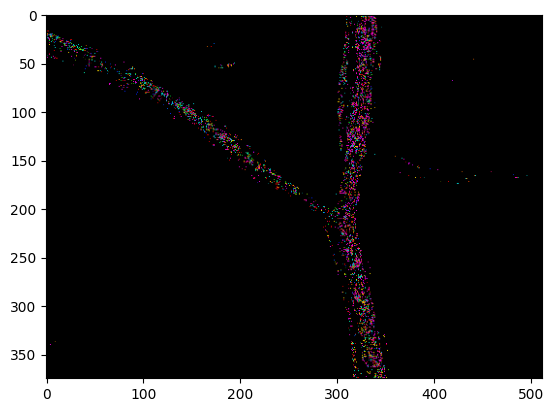

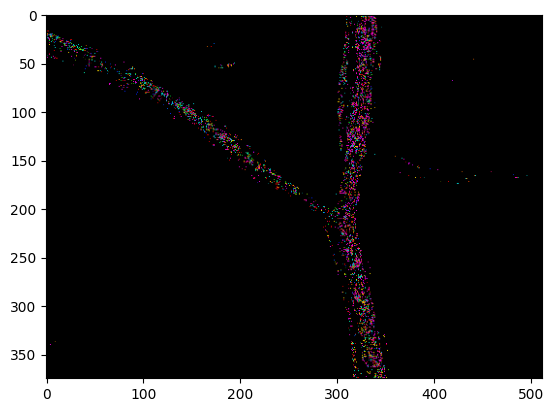

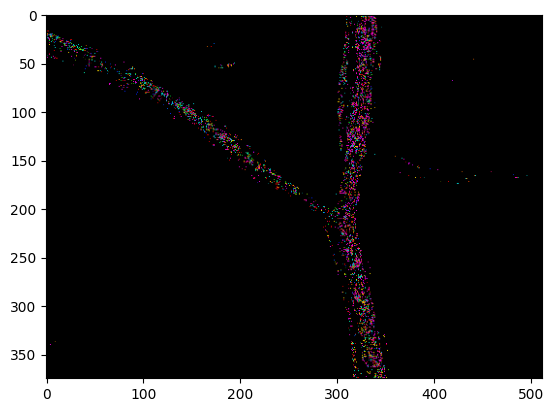

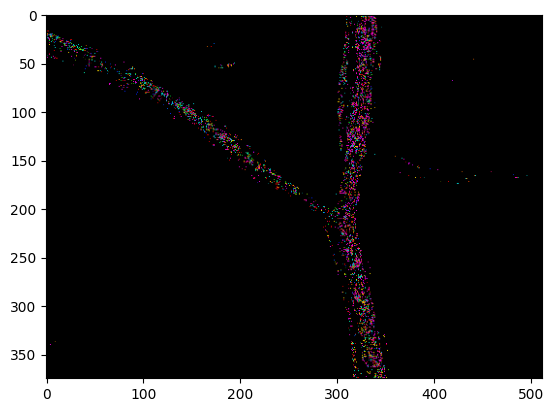

In [7]:
kernel = np.ones((3,3), np.uint8)
color_size = [np.shape(color_out)[2], np.shape(color_out)[1]]
print(np.shape(color_out))
print(frame_res[0]//4, frame_res[1]//4)

for i, edge in enumerate(edge_list):
    edge_mask_start = np.zeros(frame_res)
    start_node, end_node = (edge.edge_name[0], edge.edge_name[1])
    edge_skel = edge.video_analysis.nx_graph_pruned[start_node][end_node]['pixel_list']
    for coord in edge_skel:
        edge_mask_start[coord] = 1
    edge_mask = cv2.dilate(edge_mask_start, kernel, iterations = target_length//2)
    edge_mask = cv2.resize(edge_mask, color_size)
    fig, ax = plt.subplots()
    ax.imshow(color_out[0])


In [38]:
images = [img_path for img_path in pivanal_path.glob('*.png')]
images = sorted(images)
# images = [img_adr for img_adr in glob(img_address)]
frame = cv2.imread(str(images[0]))
height, width, layers = frame.shape
video = cv2.VideoWriter(str(input_address.joinpath("Analysis/PIV_video.mp4")),
                        cv2.VideoWriter_fourcc(*'MP4V'),
                        10,
                        (width,height))
for image in images:
    video.write(cv2.imread(str(image)))

cv2.destroyAllWindows()
video.release()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (128, 94) to (128, 96) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


(300, 94, 128, 3)


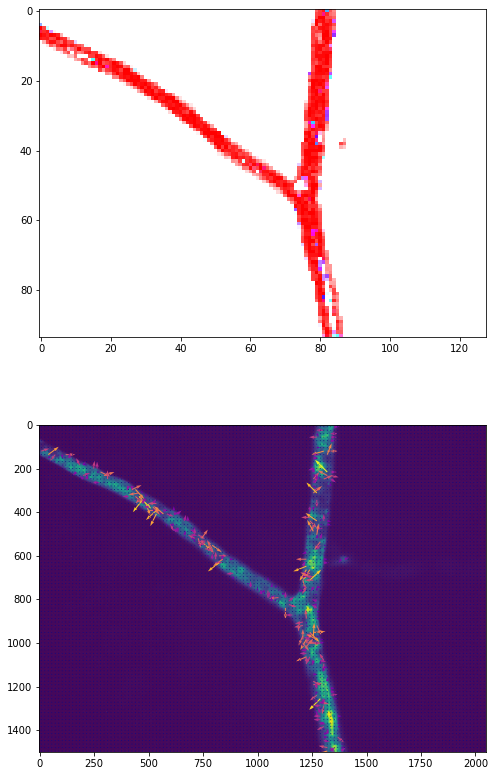

In [21]:
norms_adj = np.where(np.array(norms) < 20, norms, 0)
hues = (np.array(oris) + np.pi) / (2*np.pi)
vals = np.array(norms_adj) / np.max(norms_adj)
sats = np.ones(hues.shape)

hsvs = np.array([hues, vals, sats])
hsvs = np.transpose(hsvs, axes=[1,2,3,0])

color_out = np.array(hsv_to_rgb(hsvs) * 256, dtype=np.uint8)
# color_out = zoom(color_out, (1.0, 128, 128, 1))


print(color_out.shape)
# print(np.array(hsv_to_rgb(hsvs) * 256, dtype=np.uint8))

hsvs_mean = hsv_to_rgb(np.max(hsvs, axis=0))

imageio.mimwrite(video_address.joinpath('out.mp4'), 
                 color_out,
                fps=fps,
                quality=4)

fig, ax = plt.subplots(2, figsize=(8, 14))
# we need these flips on y since quiver uses a bottom-left origin, while our
# arrays use a top-right origin
ax[1].quiver(
    xs,
    ys,
    np.where(norm_drs < 20, dxs, 0),
    np.where(norm_drs < 20, dys, 0),
    np.where(norm_drs < 20, norm_drs, 0),
    cmap="plasma",
    angles="xy",
    scale_units="xy",
    scale=0.25,
)
ax[1].imshow(imageio.v3.imread(pics[-1]))
ax[0].imshow(hsvs_mean)
ax[0].set_aspect("equal")
# ax[1].imshow(np.max(oris, axis=0), cmap='coolwarm', vmin= -np.pi, vmax=np.pi)
plt.show()